# Recomendación de Pélicula

Los sistemas de recomendación engloban una clase de técnicas y algoritmos que pueden sugerir artículos "relevantes" a los usuarios. Predicen el comportamiento futuro basándose en datos pasados mediante multitud de técnicas. Utilizando los principios del filtrado colaborativo basado en iten, empleo el algoritmo de agrupación KNN para recomendar películas similares a los usuarios.

In [1]:
import numpy as np
import pandas as pd
from surprise import SVD
from surprise import Reader, Dataset
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [2]:
# Lectura de datos de votaciones
ratings = pd.read_csv('data/ratings.csv')

# peliculas dataset
movies = pd.read_csv('data/movies.csv')

Cantidad de datos a trabajar

In [3]:
print(movies.shape)
print(ratings.shape)


(9742, 3)
(100836, 4)


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


El marco de datos anterior es difícil de interpretar, y tiene sentido pivotarlo para facilitar su comprensión.

In [5]:
# Datos pivotantes para facilitar su interpretación y tratamiento
final_dataset = ratings.pivot(index = 'movieId', columns = 'userId', values = 'rating')
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# sustituye los NAs por 0s
final_dataset.fillna(0, inplace = True)
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


Los datos en este formato son mucho más sencillos de interpretar (por ejemplo, podemos ver que el usuario "1" ha valorado las películas "1" y "3", pero no ninguna otra de las cinco primeras películas), y serán más fáciles de procesar.

## Limpieza de datos + visualizaciones

Tiene sentido visualizar las valoraciones que los usuarios asignan a las películas en su conjunto (tanto si a la gente le gustan de media las películas de este conjunto de datos como si no).

Text(0, 0.5, 'Nº de usuarios que han votado')

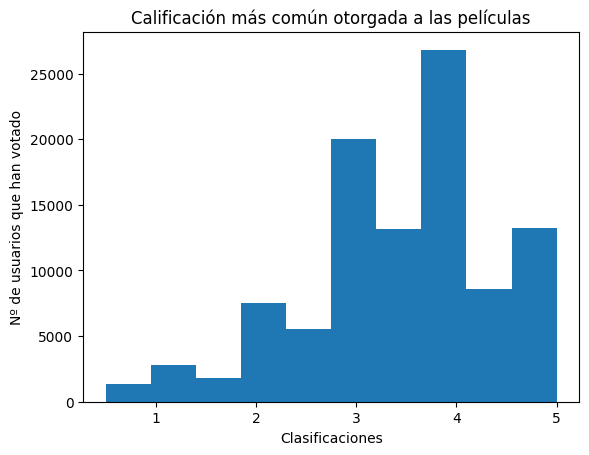

In [7]:
ratings['rating'].plot(kind='hist')
plt.title('Calificación más común otorgada a las películas')
plt.xlabel('Clasificaciones')
plt.ylabel('Nº de usuarios que han votado')

Parece que a la mayoría de la gente le gustan las películas de este conjunto de datos, siendo 4 estrellas la calificación más común.

Gran parte del conjunto de datos está formado por ceros, ya que no todo el mundo ha valorado todas las películas. Esto crea un problema, ya que no querríamos películas que hayan sido valoradas por un pequeño número de usuarios porque no es lo suficientemente creíble. Del mismo modo, tampoco deberían tenerse en cuenta los usuarios que sólo han valorado un puñado de películas.

In [8]:
# Contar el número de usuarios que han valorado cada película
no_user_voted = ratings.groupby('movieId')['rating'].agg('count')
# Contar el número de películas que fueron calificadas por cada usuario
no_movies_voted = ratings.groupby('userId')['rating'].agg('count')


In [9]:
no_user_voted


movieId
1         215
2         110
3          52
4           7
5          49
         ... 
193581      1
193583      1
193585      1
193587      1
193609      1
Name: rating, Length: 9724, dtype: int64

In [10]:
no_movies_voted


userId
1       232
2        29
3        39
4       216
5        44
       ... 
606    1115
607     187
608     831
609      37
610    1302
Name: rating, Length: 610, dtype: int64

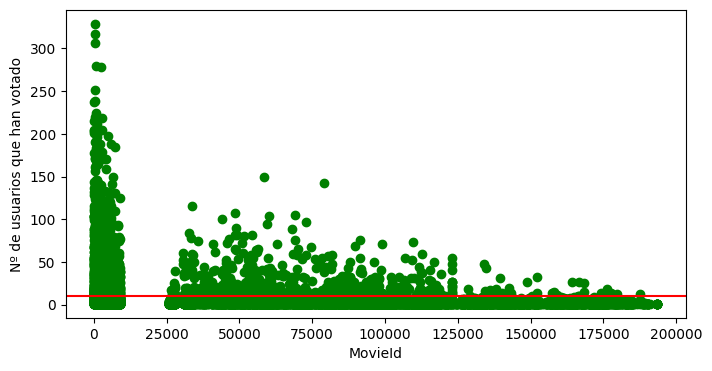

In [11]:
f,ax = plt.subplots(1,1,figsize=(8,4))
plt.scatter(no_user_voted.index,no_user_voted,color='green')
plt.axhline(y=10,color='red')
plt.xlabel('MovieId')
plt.ylabel('Nº de usuarios que han votado')
plt.show()

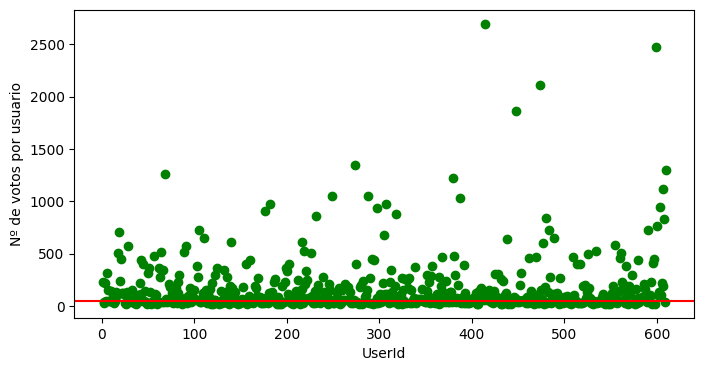

In [12]:
f,ax = plt.subplots(1,1,figsize=(8,4))
plt.scatter(no_movies_voted.index,no_movies_voted,color='green')
plt.axhline(y=50,color='red')
plt.xlabel('UserId')
plt.ylabel('Nº de votos por usuario')
plt.show()

In [13]:
# Subconjunto de datos para incluir sólo a los usuarios que han valorado 50 películas o más.
final_dataset = final_dataset.loc[:,no_movies_voted[no_movies_voted > 50].index]
final_dataset

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
4,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# crear la matriz csr
csr_data = csr_matrix(final_dataset.values)
# restablecer los índices
final_dataset.reset_index(inplace=True)


In [15]:
print(csr_data)

  (0, 0)	4.0
  (0, 3)	4.5
  (0, 6)	2.5
  (0, 8)	4.5
  (0, 9)	3.5
  (0, 10)	4.0
  (0, 12)	3.5
  (0, 16)	3.0
  (0, 19)	3.0
  (0, 20)	3.0
  (0, 25)	5.0
  (0, 28)	5.0
  (0, 29)	4.0
  (0, 31)	3.0
  (0, 34)	5.0
  (0, 38)	5.0
  (0, 39)	4.0
  (0, 40)	4.0
  (0, 41)	2.5
  (0, 43)	4.5
  (0, 46)	0.5
  (0, 47)	4.0
  (0, 50)	2.5
  (0, 53)	4.0
  (0, 55)	3.0
  :	:
  (9694, 286)	4.5
  (9695, 31)	3.0
  (9695, 236)	4.0
  (9695, 365)	4.0
  (9696, 197)	3.5
  (9697, 129)	4.5
  (9698, 317)	4.0
  (9699, 197)	4.5
  (9702, 115)	4.0
  (9702, 155)	3.5
  (9703, 197)	2.5
  (9704, 127)	1.0
  (9705, 286)	2.5
  (9706, 31)	3.5
  (9713, 115)	4.5
  (9714, 115)	3.5
  (9715, 115)	3.0
  (9716, 115)	4.0
  (9717, 115)	4.0
  (9718, 115)	3.5
  (9719, 115)	4.0
  (9720, 115)	3.5
  (9721, 115)	3.5
  (9722, 115)	3.5
  (9723, 205)	4.0


El conjunto de datos está listo para el entrenamiento y ya podemos construir el modelo ML.

## Modelo ML + Recomendación

In [16]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [17]:
def get_movie_recommendation(movie_name, n):
    n_movies_to_recommend = n
    # obtener todas las películas que contengan el nombre de la película dada (por ejemplo, si el valor de entrada es Toy Story, devuelve todas las instancias de Batman)
    movie_list = movies[movies['title'].str.contains(movie_name)]
    
    if len(movie_list):
        # obtener el índice de la película a partir del nombre introducido
        movie_idx = movie_list.iloc[0]['movieId']
        movie_idx = final_dataset[final_dataset['movieId'] == movie_idx].index[0]
        # encontrar los vecinos más cercanos
        distances, indices = knn.kneighbors(csr_data[movie_idx], n_neighbors = n_movies_to_recommend + 1 )
        # crear una lista con el índice de la película y su distancia correspondiente
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
        # crear un marco de datos que muestre las "n" películas recomendadas
        recommend_frame = []
        for val in rec_movie_indices:
            movie_idx = final_dataset.iloc[val[0]]['movieId']
            idx = movies[movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_recommend + 1))
        return df
    else:
        return "No se han encontrado películas. Por favor, compruebe su entrada"


funcion("Pelicula", "Top de peliculas mas cercanas")

funcion(texto, numero)

In [18]:
get_movie_recommendation('Toy Story', 10)

,Title,Distance
1,Groundhog Day (1993),0.399495
2,"Lion King, The (1994)",0.398578
3,Pulp Fiction (1994),0.398293
4,Star Wars: Episode VI - Return of the Jedi (1983),0.390663
5,Apollo 13 (1995),0.384633
6,Shrek (2001),0.381472
7,Star Wars: Episode IV - A New Hope (1977),0.380789
8,Toy Story 2 (1999),0.371637
9,Forrest Gump (1994),0.356542
10,Jurassic Park (1993),0.334884
